## Data Handling
1. 날짜, 시계열 관련 전처리

### 1. data : 날짜, 시계열 관련 전처리 
1. year, month 를 분리하여 특성으로
2. Add Feature : 'previous interest rate'
 

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
date_df_dic = {}
q1 = pd.read_csv('dataframes/selected_df_q1.csv')
q2 = pd.read_csv('dataframes/selected_df_q2.csv')
q3 = pd.read_csv('dataframes/selected_df_q3.csv')
date_df_dic['q1'] = q1
date_df_dic['q2'] = q2
date_df_dic['q3'] = q3

In [12]:
q2['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d')).dt.year.value_counts()


date
1959    12
2008    12
1994    12
1995    12
1996    12
        ..
1986    12
1987    12
1988    12
1989    12
2024     1
Name: count, Length: 66, dtype: int64

In [32]:
for q, df in date_df_dic.items() : 
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['previous interest rate'] = df['interest rate'].shift(1)
    df = df.fillna(method='bfill')
    date_df_dic[q] = df

date_df_dic['q2'].head()


C:\Users\Skku\AppData\Local\Temp\ipykernel_2732\3369622445.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
C:\Users\Skku\AppData\Local\Temp\ipykernel_2732\3369622445.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
C:\Users\Skku\AppData\Local\Temp\ipykernel_2732\3369622445.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


,date,CPI,CPI_yoy,CPI_mom,coreCPI,coreCPI_yoy,coreCPI_mom,PCE,corePCE,PPI,PPI_yoy,Nonfarm,industrial production,interest rate,year,month,previous interest rate
0,1959-01-01,-0.686280,-0.582361,-0.387539,-0.707911,-0.257584,-1.111179,-0.416058,-0.765994,-0.743635,-0.374436,-1.035422,-0.809954,2.48,1959,1,2.48
1,1959-02-01,-0.686344,-0.666214,-0.925723,-0.707911,-0.384491,-1.111179,-0.415661,-0.765748,-0.743635,-0.374436,-1.031570,-0.801329,2.43,1959,2,2.48
2,1959-03-01,-0.686536,-0.903867,-1.140870,-0.707281,-0.386599,0.346955,-0.415308,-0.765583,-0.743635,-0.488193,-1.025590,-0.794862,2.80,1959,3,2.43
3,1959-04-01,-0.686472,-0.974649,-0.710539,-0.707281,-0.386599,-1.111179,-0.415365,-0.765091,-0.742757,-0.374796,-1.019958,-0.785158,2.96,1959,4,2.80
4,1959-05-01,-0.686087,-0.904152,-0.172429,-0.706651,-0.262660,0.342095,-0.414922,-0.764959,-0.742757,-0.431673,-1.015757,-0.778149,2.90,1959,5,2.96


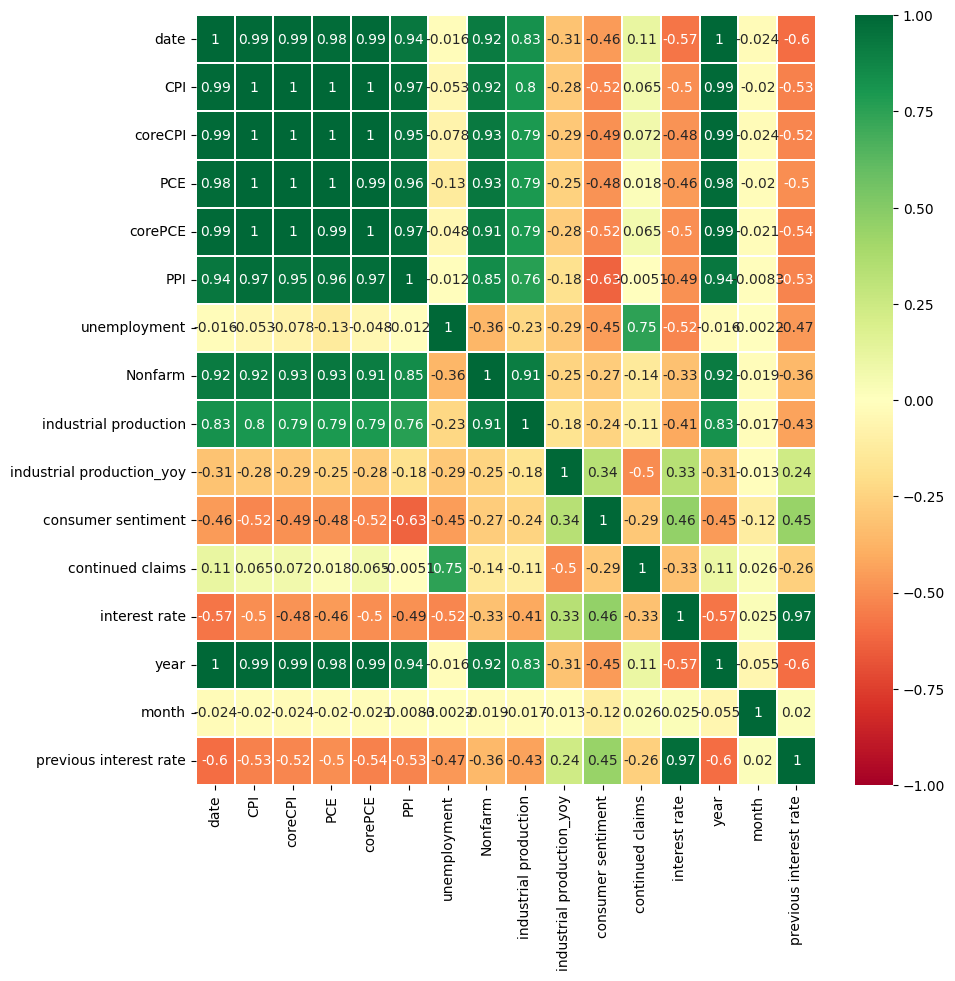

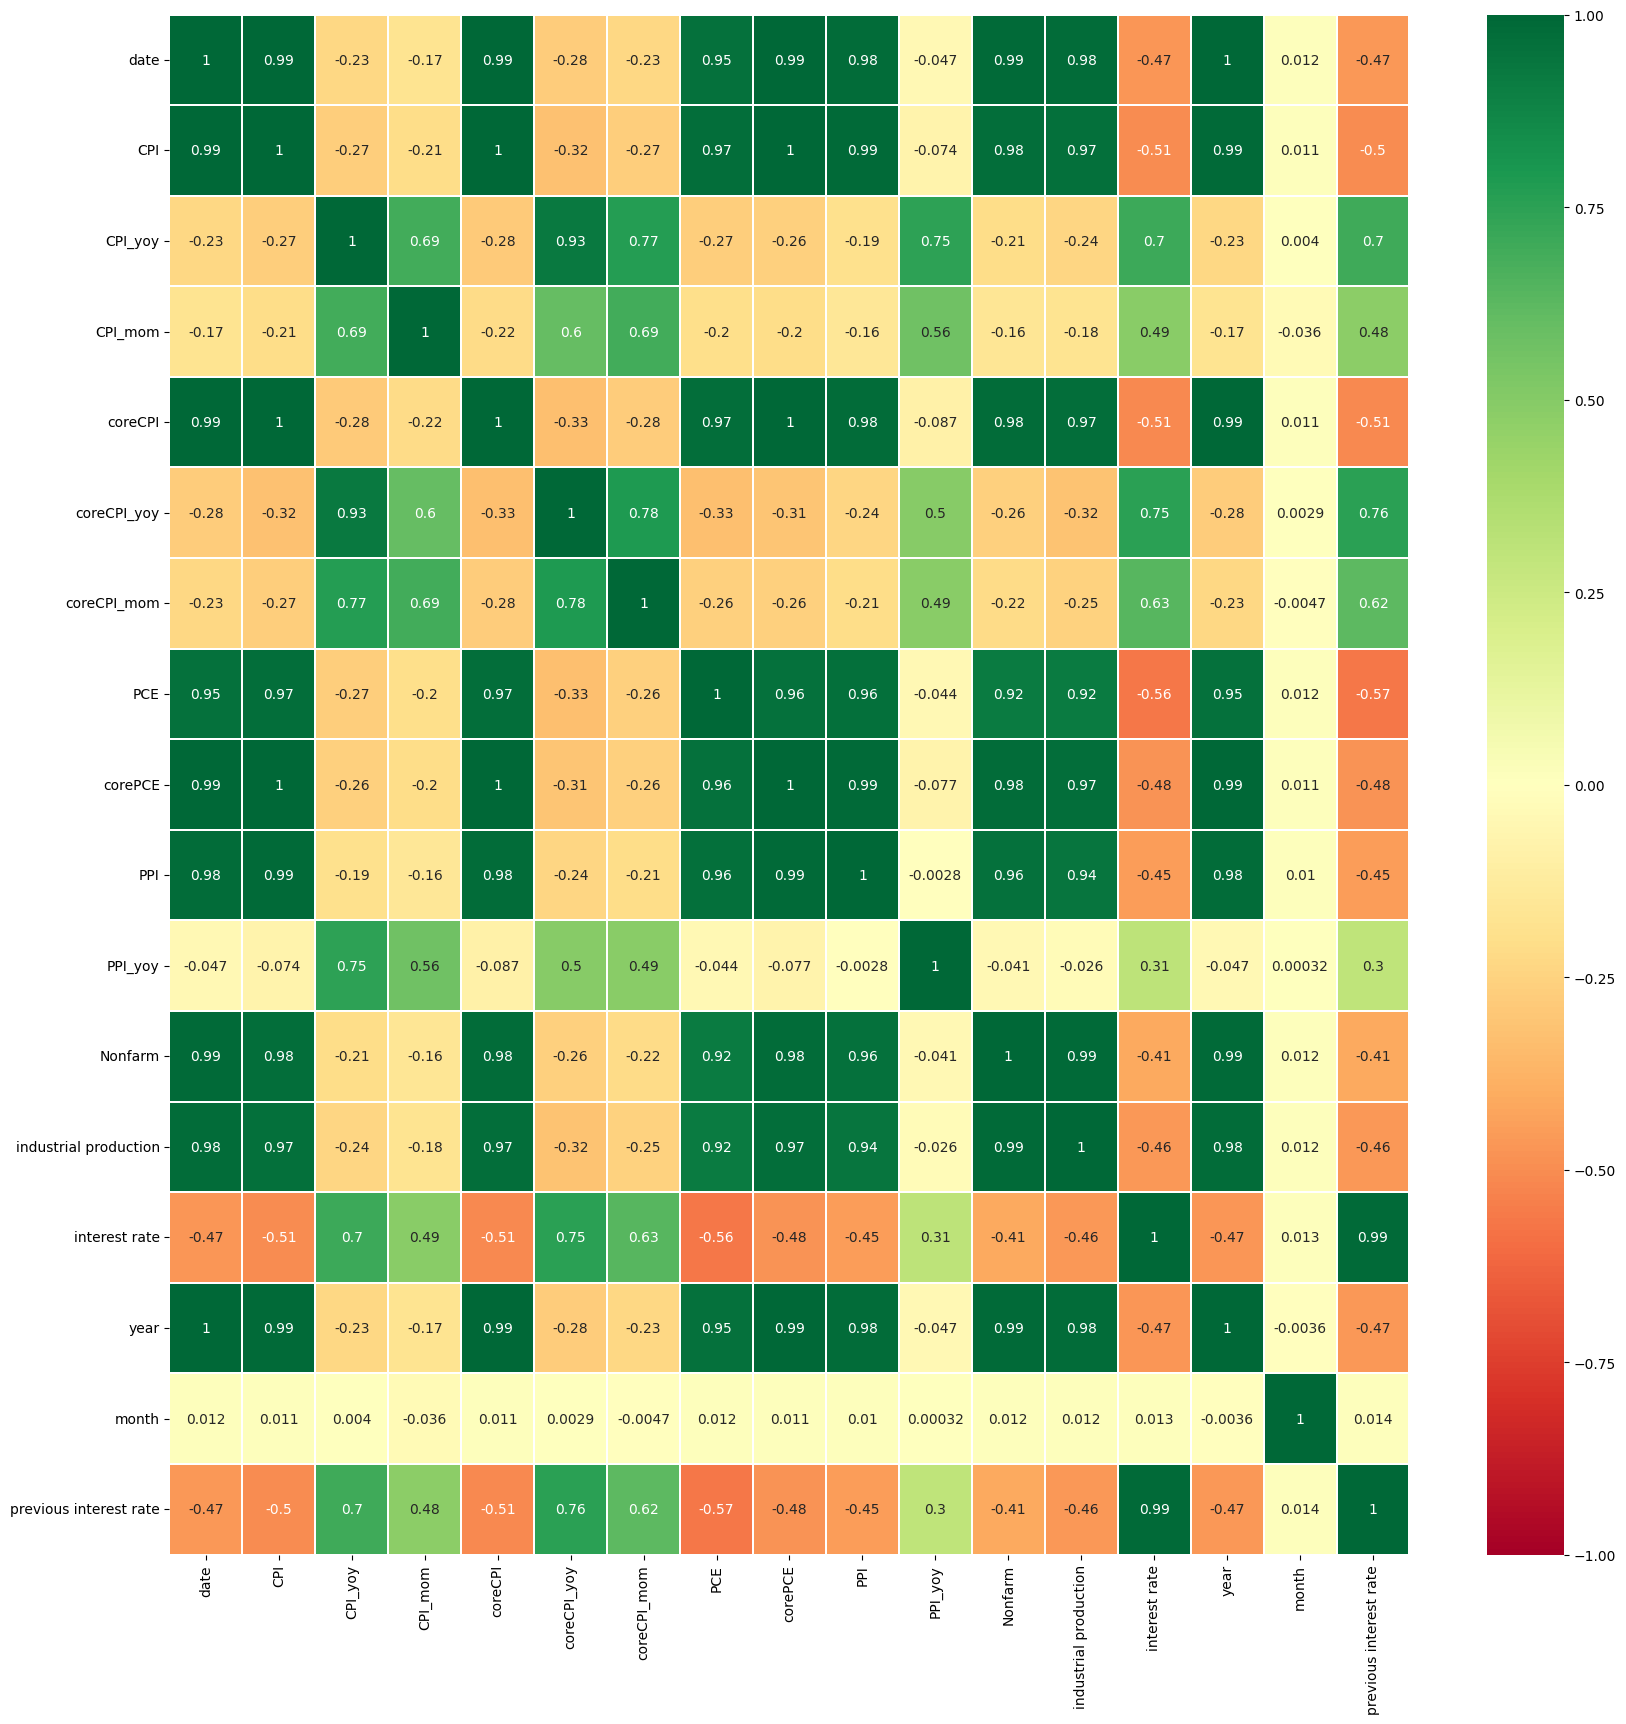

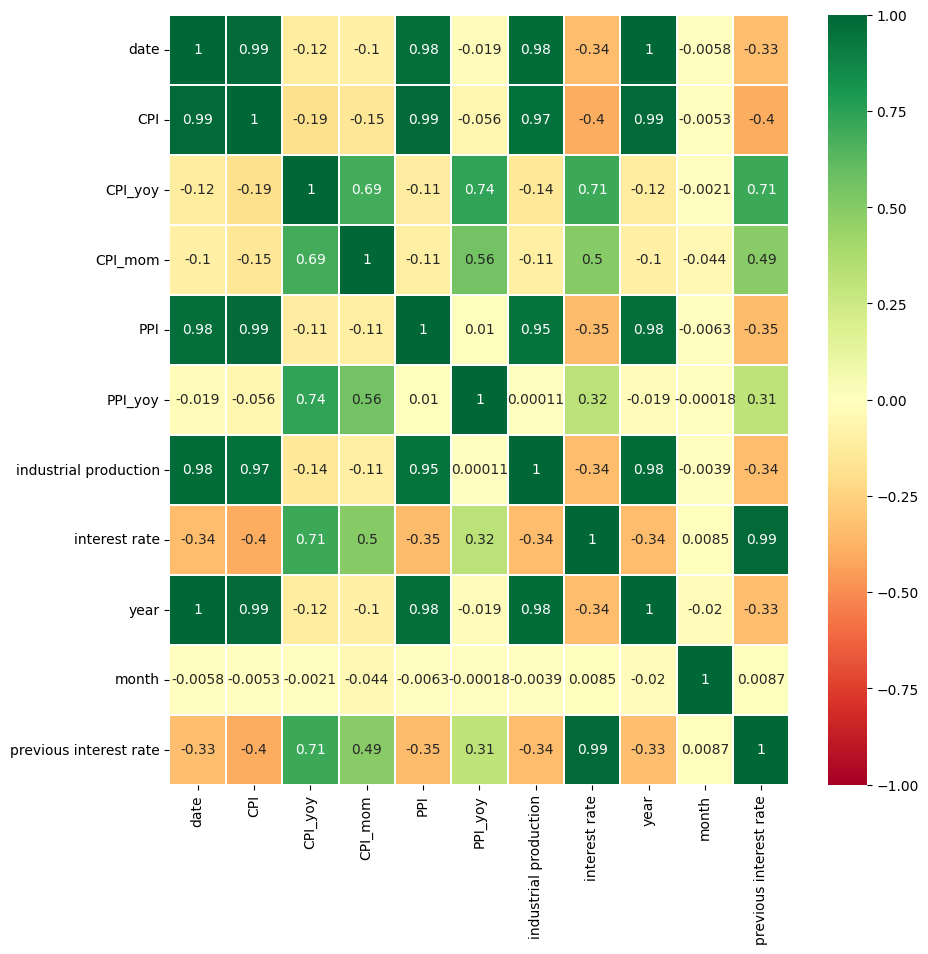

In [34]:
size_dic = {'q1':10, 'q2':20, 'q3':10}


for q, size in size_dic.items():
    temp_df = date_df_dic[q]
    #temp_df = date_df_dic[q].loc[:, date_df_dic[q].columns != 'date']
    fig, ax = plt.subplots(figsize=(size,size)) 
    sns.heatmap(temp_df.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='RdYlGn', ax=ax)
    plt.savefig(f'images/selected_correlation_{q}.png')

#### date 전처리 결과
1. date, year는 interest rate와 거의 동일한 수준의 상관관계를 가진다. => year를 레이블 인코딩하여 모델 input으로 
2. previous interest rate는 0.99의 상관 관계를 가진다. => 스케일링 없이 그대로 모델 input으로 넣겠다. 

- DataPreprocessing 코드를 수정해 반영했다.

### Federal Funds Target Range 
- Effective Funds rate(실질 연방 금리)대신 목표연방금리 써보기 
- 실질연방금리는 1954부터 Monthly, 목표연방금리는 1982년부터 Daily
- 금리 외 다른 지표들은 한 달동안 계속 같은 데이터로 채워질텐데 그럼면 데이터 신뢰도에 큰 손상을 입힐 것으로 예상
- 취소

In [14]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import fredpy as fp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
# .env에서 api_key 가져오기 
load_dotenv()

FRED_API_KEY = os.getenv('FRED_API_KEY')

# fredpy
plt.style.use('classic')
plt.rcParams.update({'figure.facecolor': 'white'})

fp.api_key = FRED_API_KEY

enddate=(datetime.now() + timedelta(days=-1)).strftime('%Y-%m-%d')


In [32]:
code = 'DFEDTARU'
target = fp.series(code, enddate)
df1 = pd.DataFrame({'date':target.data.index, 'interest rate' : target.data.values})
df1

,date,interest rate
0,2008-12-16,0.25
1,2008-12-17,0.25
2,2008-12-18,0.25
3,2008-12-19,0.25
4,2008-12-20,0.25
...,...,...
5777,2024-10-10,5.00
5778,2024-10-11,5.00
5779,2024-10-12,5.00
5780,2024-10-13,5.00


In [33]:
code = 'DFEDTAR'
target_past = fp.series(code, enddate)
df2 = pd.DataFrame({'date':target_past.data.index, 'interest rate' : target_past.data.values})
df2

,date,interest rate
0,1982-09-27,10.25
1,1982-09-28,10.25
2,1982-09-29,10.25
3,1982-09-30,10.25
4,1982-10-01,10.00
...,...,...
9572,2008-12-11,1.00
9573,2008-12-12,1.00
9574,2008-12-13,1.00
9575,2008-12-14,1.00


In [34]:
df_IR = pd.concat([df1,df2],ignore_index=True,axis=0)
df_IR

,date,interest rate
0,2008-12-16,0.25
1,2008-12-17,0.25
2,2008-12-18,0.25
3,2008-12-19,0.25
4,2008-12-20,0.25
...,...,...
15354,2008-12-11,1.00
15355,2008-12-12,1.00
15356,2008-12-13,1.00
15357,2008-12-14,1.00


In [30]:
# PPIfd : PPI final demand
# AHE : Average Hourly Earnings
# GDP : real GDP growth rate 

code_dic = {'CPI': 'CPIAUCSL', 'coreCPI':'CPILFESL', 'PCE':'PCE', 'corePCE':'PCEPI', 'PPI':'PPIACO', 'PPIfd':'PPIFIS', 'corePPIfd':'PPIFES', 
            'unemployment':'UNRATE', 'Nonfarm':'PAYEMS', 'AHE':'CES0500000003',  'job openings':'JTSJOL',
            'GDP':'A191RL1Q225SBEA', 'retail':'MARTSMPCSM44X72USS', 'industrial production':'INDPRO', 'OECD leading':'USALOLITONOSTSAM','consumer sentiment':'UMCSENT'}

claims_dic = {'initial claims': 'ICSA', 'continued claims':'CCSA'}

code_dic.values()


# fredpy로 max 기간만큼 가져오기
# yoy, mom 계산 후 추가
# df로 변환

df_dic = {}

# df_dic['CPI'].apc().data, df_dic['CPI'].data.pct_change()*100

for key in code_dic.keys() : 
     s = fp.series(code_dic[key],enddate)
     yoy = s.apc().data
     mom = s.data.pct_change()*100
     df_dic[key] = pd.DataFrame({'date': s.data.index, f'{key}' : s.data.values})
     df_dic[f'{key}_yoy'] = pd.DataFrame({'date': yoy.index, f'{key}_yoy' : yoy.values})
     df_dic[f'{key}_mom'] = pd.DataFrame({'date': mom.index, f'{key}_mom' : mom.values})


# claims 는 한달에 3~4번 발표
# 월 별로 묶어서 평균냄, yoy/mom 없음

for key in claims_dic.keys() :
    s = fp.series(claims_dic[key],enddate)
    temp = pd.DataFrame({'date':s.data.index, f'{key}':s.data.values})
    temp['date'] = pd.to_datetime(temp['date']).dt.strftime('%Y-%m-01')
    temp = temp.groupby(['date']).mean()
    temp = pd.DataFrame({'date':temp[key].index,f'{key}':temp[key].values})
    df_dic[key]= temp

df_dic['initial claims'], df_dic['continued claims']


# 모든 df 병합
from functools import reduce

# date type 맞춰주기
for df in df_dic.values():
    df['date'] = pd.to_datetime(df['date'])

merged_df = reduce(lambda df1, df2 : pd.merge(df1,df2,on='date',how='outer'),df_dic.values())
merged_df


C:\Users\Skku\AppData\Local\Temp\ipykernel_14444\1469573932.py:25: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mom = s.data.pct_change()*100


,date,CPI,CPI_yoy,CPI_mom,coreCPI,coreCPI_yoy,coreCPI_mom,PCE,PCE_yoy,PCE_mom,...,industrial production_yoy,industrial production_mom,OECD leading,OECD leading_yoy,OECD leading_mom,consumer sentiment,consumer sentiment_yoy,consumer sentiment_mom,initial claims,continued claims
0,1913-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1913-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1913-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1913-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1913-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,2024-06-01,313.049,2.975629,-0.056190,318.346,3.276939,0.064751,19747.5,5.364394,0.254857,...,0.877996,0.062200,NaN,NaN,NaN,68.2,6.230530,-1.302460,236800.0,1833800.0
1338,2024-07-01,313.534,2.923566,0.154928,318.872,3.213193,0.165229,19849.9,5.301716,0.518547,...,-0.743556,-0.943069,NaN,NaN,NaN,66.4,-7.132867,-2.639296,238250.0,1861000.0
1339,2024-08-01,314.121,2.591227,0.187221,319.768,3.265559,0.280990,19897.1,5.211087,0.237785,...,0.042485,0.814323,NaN,NaN,NaN,67.9,-2.161383,2.259036,231000.0,1852400.0
1340,2024-09-01,314.686,2.407513,0.179867,320.767,3.258714,0.312414,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224250.0,1832000.0


In [35]:
# 금리 기준으로 Join
# df['col'].diff() 로 금리 변동 계산

merged_df = merged_df.merge(df_IR,how='right', on='date')
# 전 금리 값 
merged_df['previous interest rate'] = merged_df['interest rate'].shift(1)
# 다음 금리 값 
merged_df['next interest rate'] = merged_df['interest rate'].shift(-1)

# 현재 금리 - 전 금리
merged_df['previous change'] = merged_df['interest rate'] - merged_df['previous interest rate']

# 다음 금리 - 현재 금리 
merged_df['present change'] = merged_df['next interest rate'] - merged_df['interest rate']

try :
    os.makedirs('dataframes')
    merged_df.to_csv('dataframes/target_merged_df.csv',index=False)
except : 
    merged_df.to_csv('dataframes/target_merged_df.csv',index=False)

merged_df

,date,CPI,CPI_yoy,CPI_mom,coreCPI,coreCPI_yoy,coreCPI_mom,PCE,PCE_yoy,PCE_mom,...,consumer sentiment_yoy,consumer sentiment_mom,initial claims,continued claims,values,interest rate,previous interest rate,next interest rate,previous change,present change
0,2008-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.25,0.25,NaN,0.25,NaN,0.0
1,2008-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.25,0.25,0.25,0.25,0.0,0.0
2,2008-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.25,0.25,0.25,0.25,0.0,0.0
3,2008-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.25,0.25,0.25,0.25,0.0,0.0
4,2008-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.25,0.25,0.25,0.25,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15354,2008-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.00,1.00,1.00,1.00,0.0,0.0
15355,2008-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.00,1.00,1.00,1.00,0.0,0.0
15356,2008-12-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.00,1.00,1.00,1.00,0.0,0.0
15357,2008-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.00,1.00,1.00,1.00,0.0,0.0


In [36]:
merged_df.isna().sum()

date                             0
CPI                          14855
CPI_yoy                      14855
CPI_mom                      14855
coreCPI                      14855
coreCPI_yoy                  14855
coreCPI_mom                  14855
PCE                          14856
PCE_yoy                      14856
PCE_mom                      14856
corePCE                      14856
corePCE_yoy                  14856
corePCE_mom                  14856
PPI                          14855
PPI_yoy                      14855
PPI_mom                      14855
PPIfd                        15180
PPIfd_yoy                    15192
PPIfd_mom                    15181
corePPIfd                    15185
corePPIfd_yoy                15197
corePPIfd_mom                15186
unemployment                 14855
unemployment_yoy             14855
unemployment_mom             14855
Nonfarm                      14855
Nonfarm_yoy                  14855
Nonfarm_mom                  14855
AHE                 

### 다중 대체 
- 결측치를 제외한 나머지 변수들로 해당 결측치를 예측
- 이 작업을 여러 번 반복을 통해서 신뢰성 있는 대체 값을 대체
- 성능이 좋다~

In [61]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import fredpy as fp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# 다중 대체
from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

<Axes: >

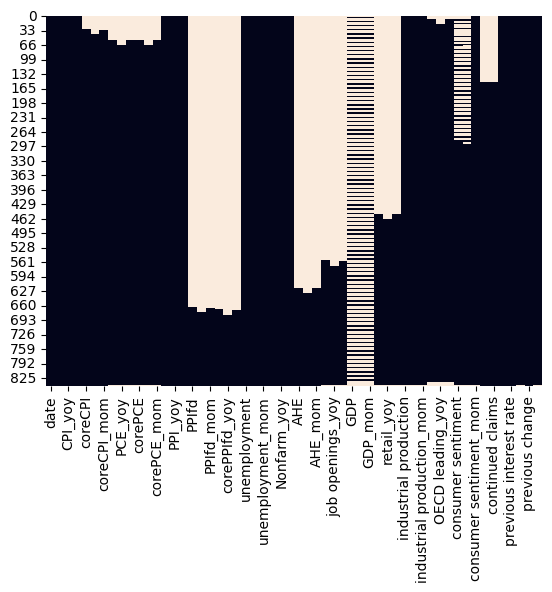

In [80]:
df = pd.read_csv('dataframes/merged_df.csv')

fig, ax = plt.subplots()
sns.heatmap(df.isna(),cbar=False, ax=ax)

0

<Axes: >

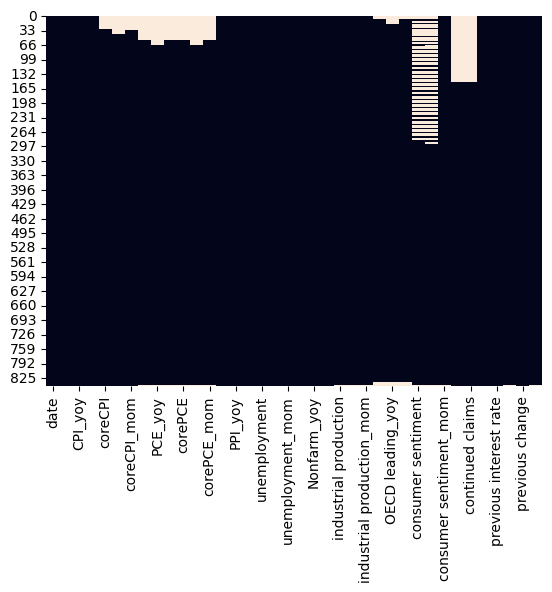

In [82]:
# 결측률이 0.3 이상인 feature는 제거함  

null_rate = 0.3
for k, cnt in df.isna().sum().items() :
    if cnt > len(df)*null_rate :
        df.drop(k,axis=1,inplace=True)

fig, ax = plt.subplots()
sns.heatmap(df.isna(),cbar=False, ax=ax)

In [64]:
# 추론을 위한 데이터 한 줄
infer_df = df.tail(1)
df.drop(df.index[-1],inplace=True)

In [65]:
# mice를 이용한 다중대체
df.isin([np.inf, -np.inf]).sum()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
dummy = pd.get_dummies(df.loc[:, (df.columns != 'date')&(df.columns != 'interest rate')&(df.columns != 'previous interest rate')&(df.columns != 'next interest rate')&(df.columns != 'previous change')& (df.columns != 'present change')])
imputer_mice = IterativeImputer(verbose=False)
imputed_df =  pd.DataFrame(imputer_mice.fit_transform(dummy))

<Axes: >

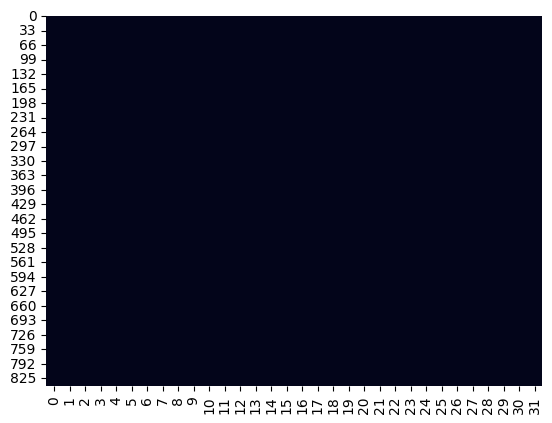

In [66]:
fig, ax = plt.subplots()
sns.heatmap(imputed_df.isna(),cbar=False, ax=ax)

In [67]:
imputed_cols = list(dummy.columns)
imputed_df.columns = imputed_cols

for k, v in imputed_df.items() : 
    df[k] = imputed_df[k]

df.isna().sum()

date                         0
CPI                          0
CPI_yoy                      0
CPI_mom                      0
coreCPI                      0
coreCPI_yoy                  0
coreCPI_mom                  0
PCE                          0
PCE_yoy                      0
PCE_mom                      0
corePCE                      0
corePCE_yoy                  0
corePCE_mom                  0
PPI                          0
PPI_yoy                      0
PPI_mom                      0
unemployment                 0
unemployment_yoy             0
unemployment_mom             0
Nonfarm                      0
Nonfarm_yoy                  0
Nonfarm_mom                  0
industrial production        0
industrial production_yoy    0
industrial production_mom    0
OECD leading                 0
OECD leading_yoy             0
OECD leading_mom             0
consumer sentiment           0
consumer sentiment_yoy       0
consumer sentiment_mom       0
initial claims               0
continue

In [68]:
df.to_csv('dataframes/mice_df.csv', index=False)
df.dropna(axis=0,inplace=True)

In [69]:
# isolation Forest를 이용한 이상치 제거 
from sklearn.ensemble import IsolationForest

# feature_set = df.loc[:,df.columns!='date'].values
# clf=IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.004), 
#                         max_features=1.0, bootstrap=False, n_jobs=-1, random_state=None, verbose=0).fit(feature_set)
# pred = clf.predict(feature_set)

feature_set = df.loc[:,df.columns!='date']
clf=IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.004), 
                        bootstrap=True, n_jobs=-1, random_state=None, verbose=0)
clf.fit(feature_set)
pred = clf.predict(feature_set)
feature_set['anomaly'] = pred
outliers=feature_set.loc[feature_set['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(feature_set['anomaly'].value_counts())


anomaly
 1    837
-1      4
Name: count, dtype: int64


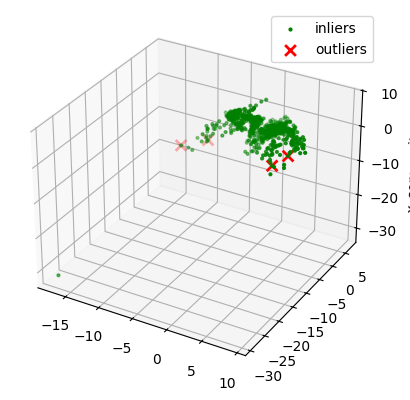

In [70]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3) 
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(feature_set)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.savefig('images/outliers3D.png')

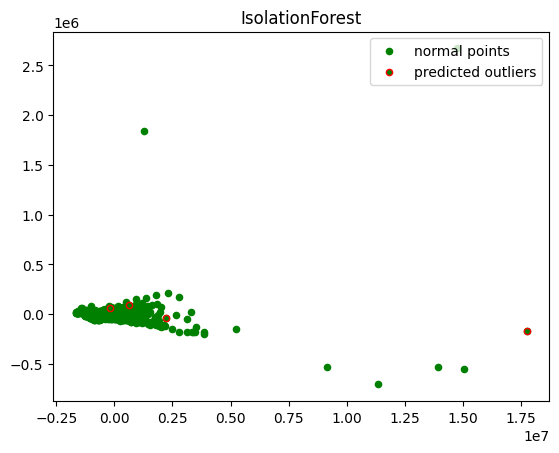

In [71]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(feature_set)
res=pd.DataFrame(pca.transform(feature_set))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.savefig('images/outliers2D.png')

In [72]:
df['anomaly'] = feature_set['anomaly']
df.drop(df[df['anomaly'] == -1].index, inplace=True)
df['anomaly'].value_counts()
df.drop('anomaly', axis=1, inplace=True)

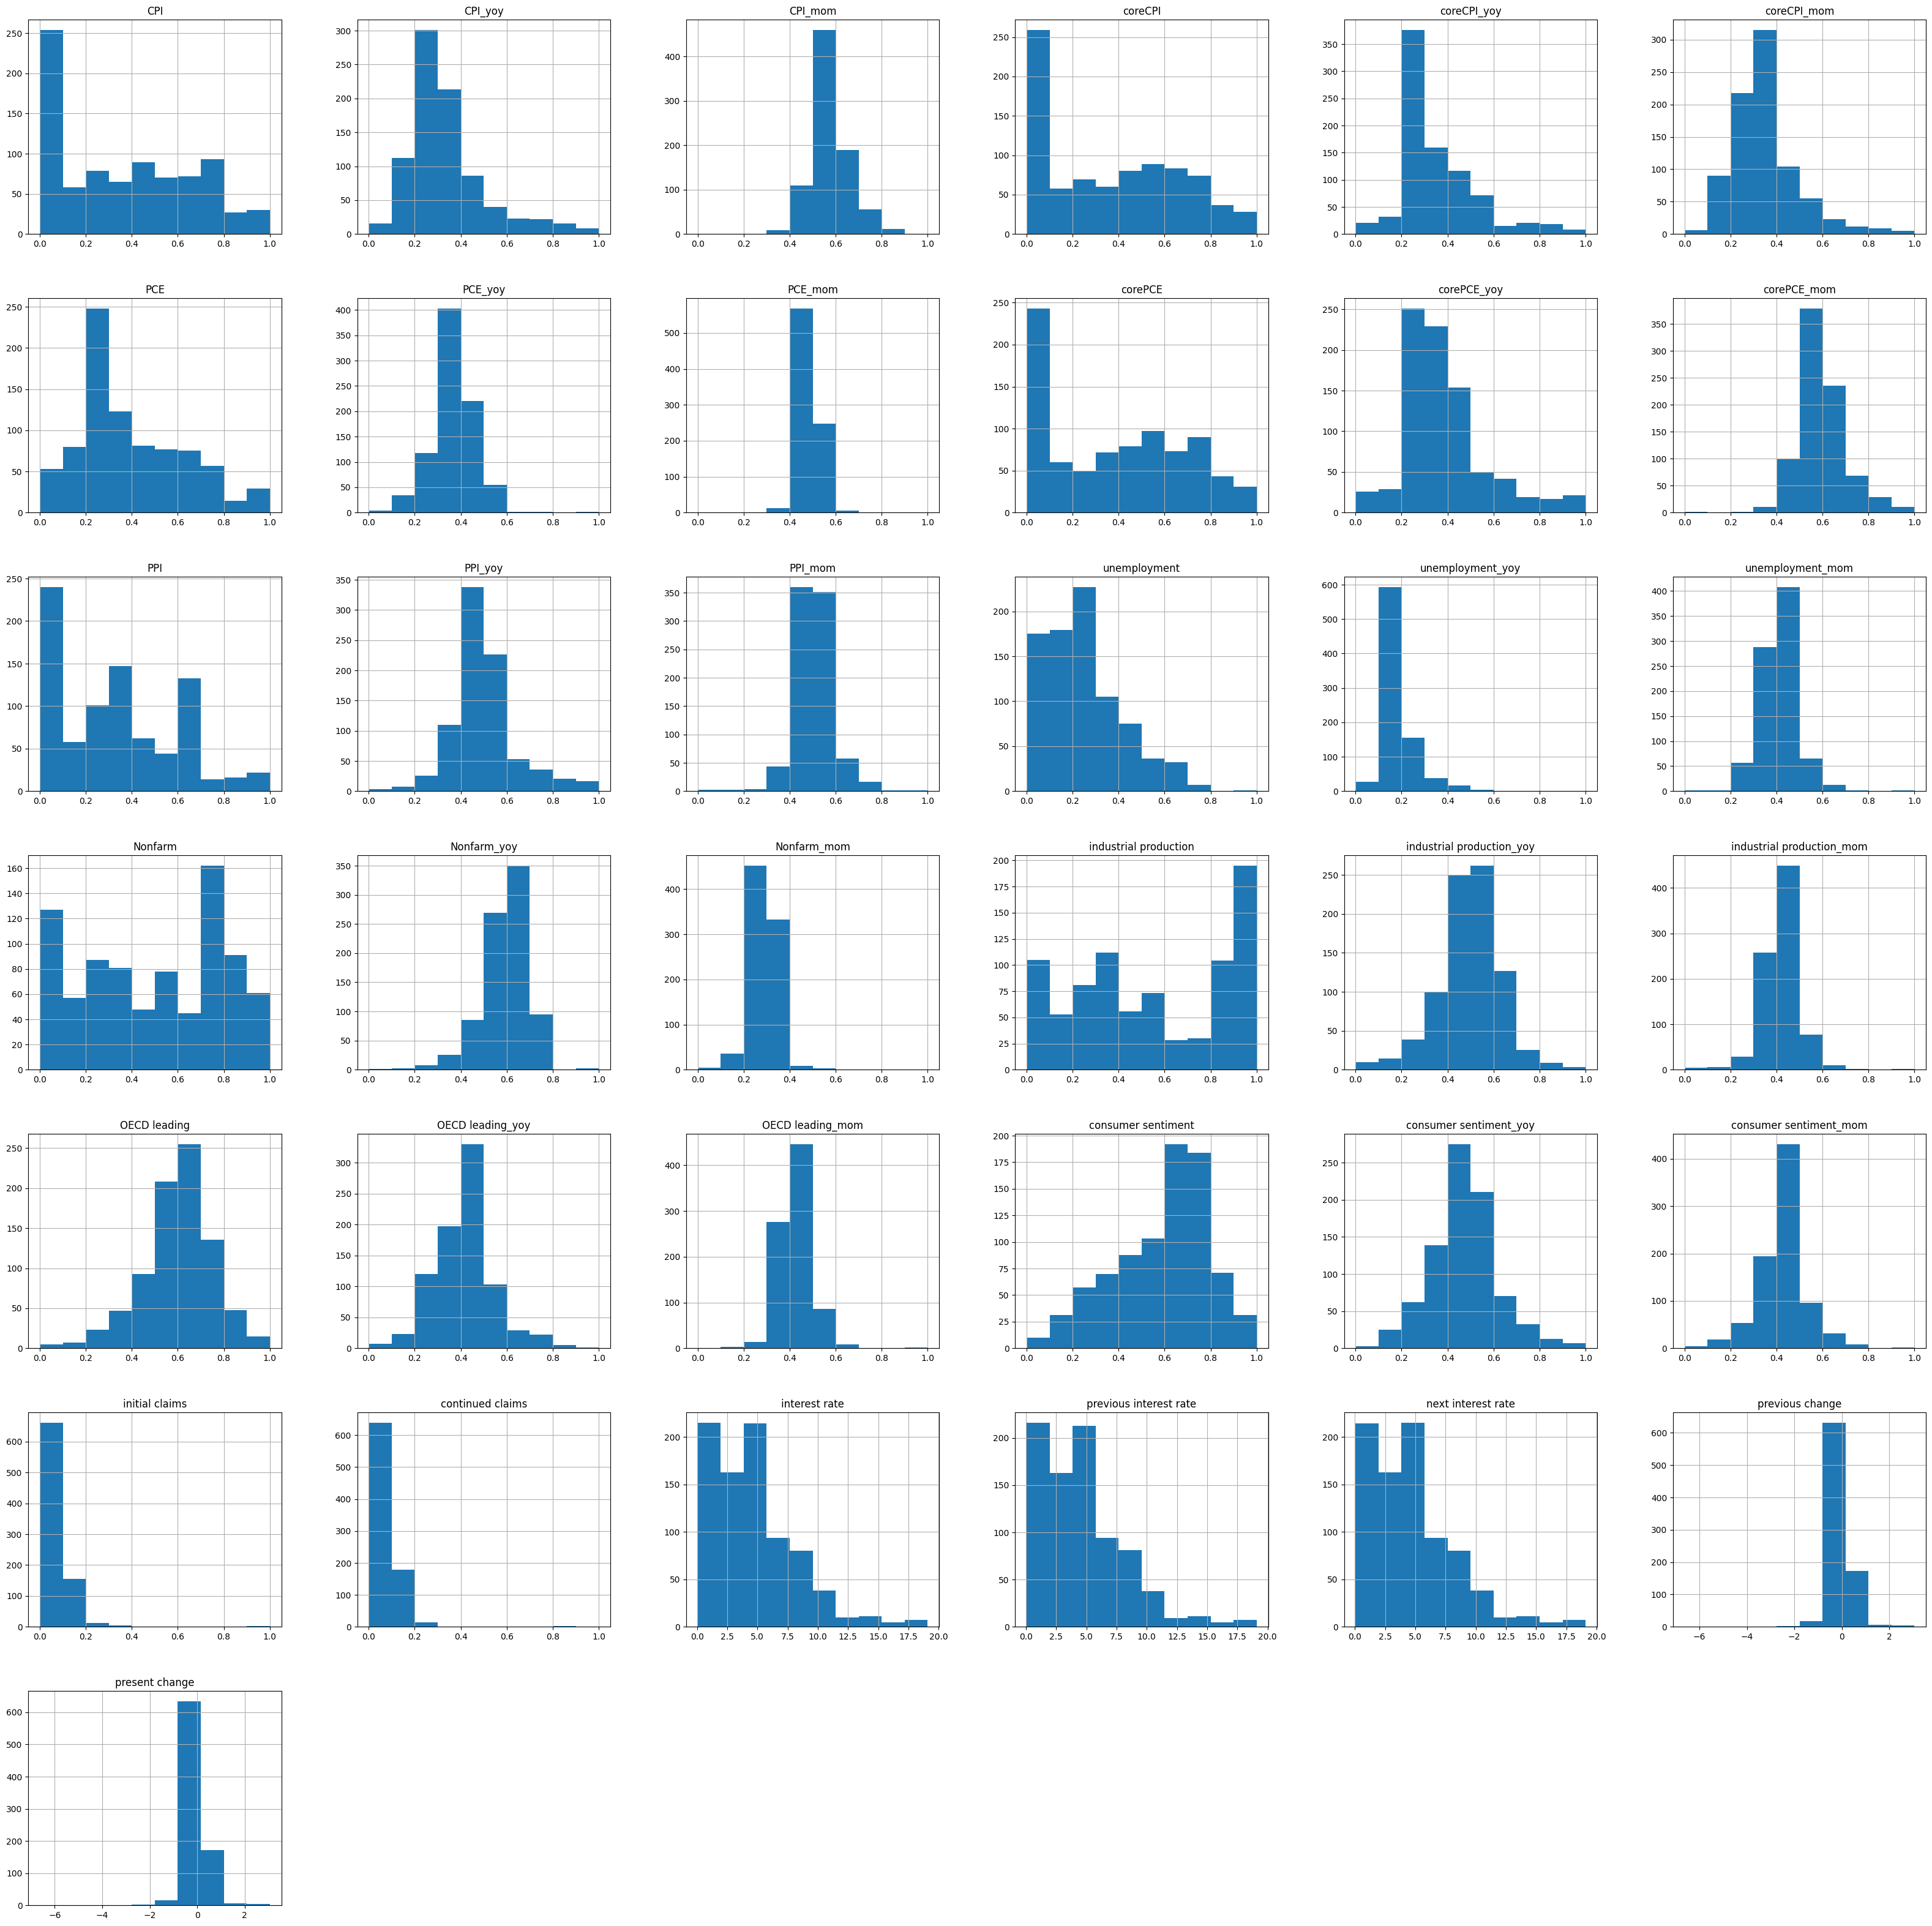

In [73]:
# 스케일링 (MinMax)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
temp = scaler.fit_transform(df.loc[:,(df.columns!='date')&(df.columns!='interest rate')&(df.columns!='previous interest rate')&(df.columns!='next interest rate')&(df.columns!='previous change')&(df.columns!='present change')])
scaled_df = df.copy()
scaled_df.loc[:,
              (df.columns!='date')&(df.columns!='interest rate')&(df.columns!='previous interest rate')&(df.columns!='next interest rate')
              &(df.columns!='previous change')&(df.columns!='present change')] = temp
scaled_df.hist(figsize=(40,40))
scaled_df.to_csv('dataframes/mice_scaled_df.csv',index=False)

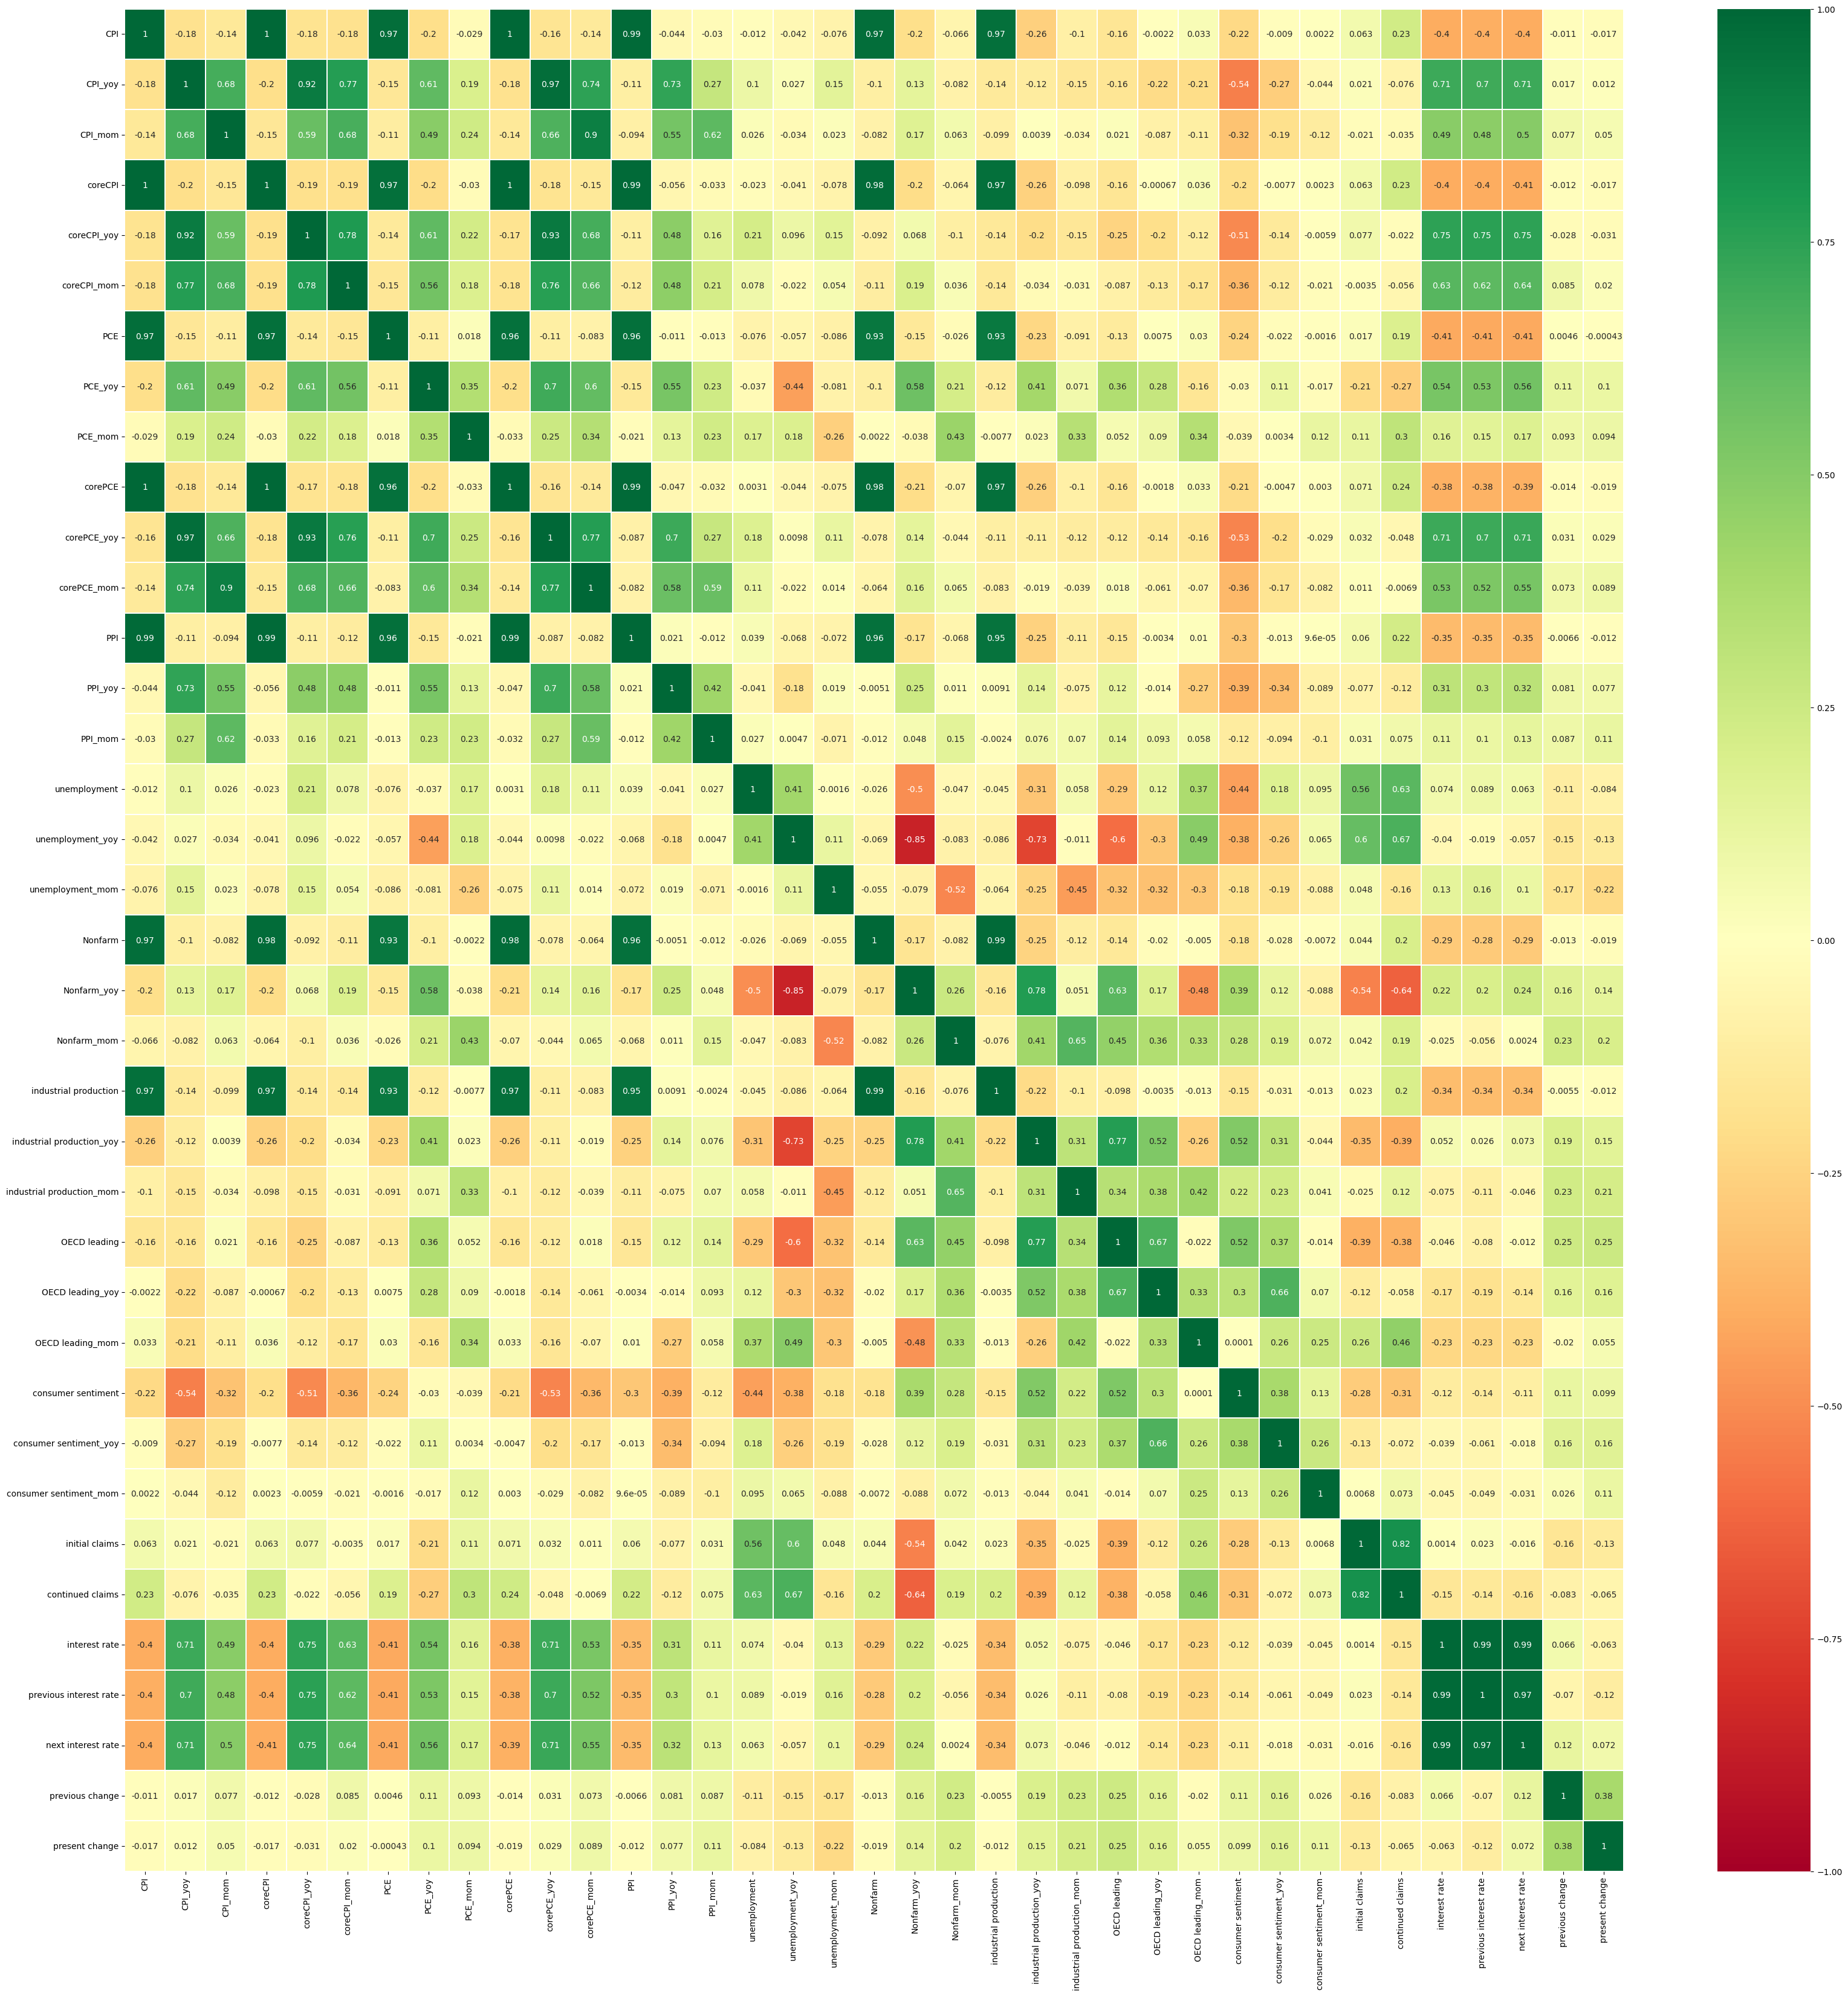

In [74]:
corr_df = df.loc[:,df.columns!='date']
fig, ax = plt.subplots(figsize=(40,40)) 
sns.heatmap(corr_df.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='RdYlGn', ax=ax)
plt.savefig('images/mice_correlation.png')

In [75]:
# 상관계수가 0.3 미만인 feature는 제거함
cols = []
MINCORR = 0.3



cols = []
for col, val in abs(scaled_df.loc[:,
              (scaled_df.columns!='date')&(scaled_df.columns!='previous interest rate')&(scaled_df.columns!='next interest rate')
              &(scaled_df.columns!='previous change')&(scaled_df.columns!='present change')].corr()['interest rate']).items() :
    if val < MINCORR :
        cols.append(col)
        scaled_df.drop(col, axis=1, inplace=True)

print(cols)
scaled_df.to_csv('dataframes/mice_selected_df.csv', index=False)
selected_df = scaled_df.copy()


['PCE_mom', 'PPI_mom', 'unemployment', 'unemployment_yoy', 'unemployment_mom', 'Nonfarm', 'Nonfarm_yoy', 'Nonfarm_mom', 'industrial production_yoy', 'industrial production_mom', 'OECD leading', 'OECD leading_yoy', 'OECD leading_mom', 'consumer sentiment', 'consumer sentiment_yoy', 'consumer sentiment_mom', 'initial claims', 'continued claims']


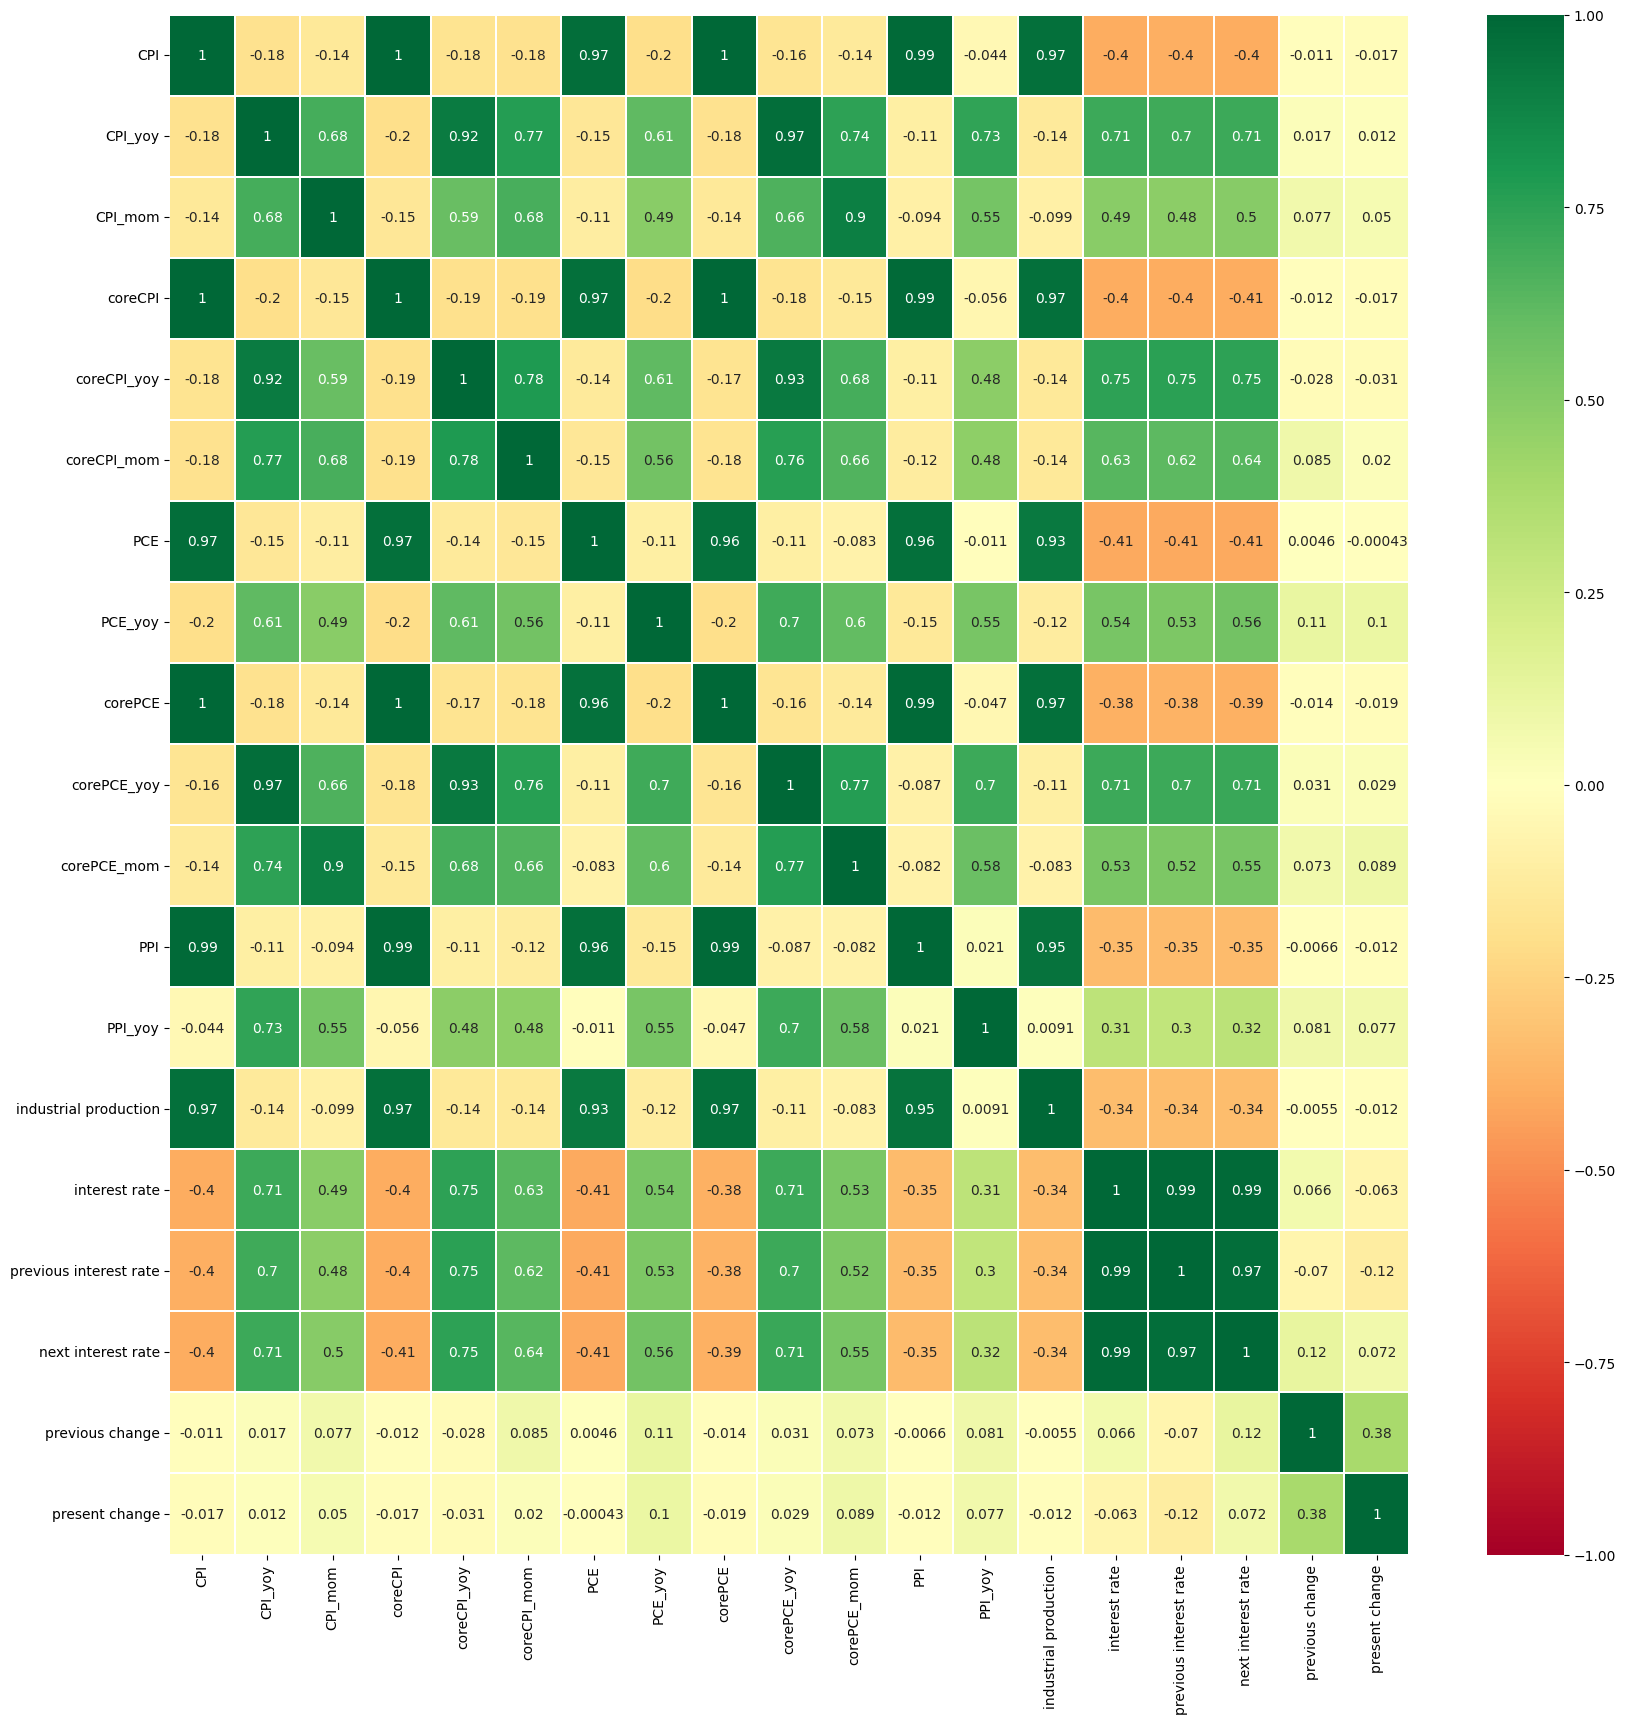

In [76]:
corr_df = selected_df.loc[:,selected_df.columns!='date']
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr_df.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='RdYlGn', ax=ax)
plt.savefig('images/mice_selected_correlation.png')

C:\Users\Skku\AppData\Local\Temp\ipykernel_11604\2788674805.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(selected_df['previous change'],kde=True)


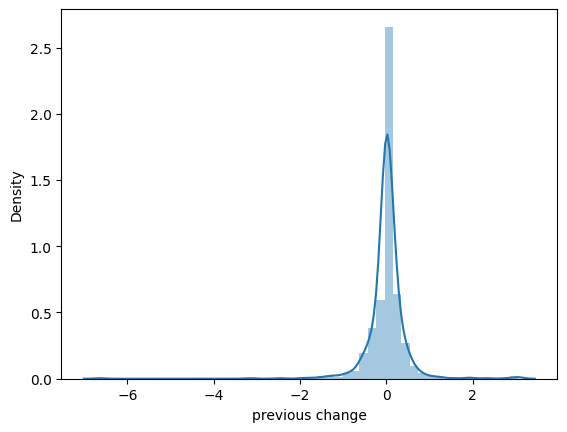

In [77]:
sns.distplot(selected_df['previous change'],kde=True)
plt.show()

### 추론 데이터 추출 후 저장

In [78]:
# 추론 데이터
# 스케일링
infer_df.loc[:,(infer_df.columns!='date')&(infer_df.columns!='interest rate')&(infer_df.columns!='previous interest rate')&(infer_df.columns!='next interest rate')&(infer_df.columns!='previous change')&(infer_df.columns!='present change')] = scaler.transform(infer_df.loc[:,(infer_df.columns!='date')&(infer_df.columns!='interest rate')&(infer_df.columns!='previous interest rate')&(infer_df.columns!='next interest rate')&(infer_df.columns!='previous change')&(infer_df.columns!='present change')])

# 컬럼 제거
infer_df.drop(cols,axis=1,inplace=True)
infer_df


C:\Users\Skku\AppData\Local\Temp\ipykernel_11604\3737603856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infer_df.drop(cols,axis=1,inplace=True)


,date,CPI,CPI_yoy,CPI_mom,coreCPI,coreCPI_yoy,coreCPI_mom,PCE,PCE_yoy,corePCE,corePCE_yoy,corePCE_mom,PPI,PPI_yoy,industrial production,interest rate,previous interest rate,next interest rate,previous change,present change
842,2024-09-01,1.001966,0.263807,0.544732,1.003421,0.337583,0.365682,NaN,NaN,NaN,NaN,NaN,0.889652,0.348722,NaN,5.13,5.33,NaN,-0.2,NaN


In [79]:
infer_df.to_csv('dataframes/infer_df.csv', index=False)

### 회귀에서 다중 분류로

In [88]:
df = pd.read_csv('dataframes/mice_selected_df.csv')
abs(df['present change']).describe()

count    837.000000
mean       0.227646
std        0.426119
min        0.000000
25%        0.020000
50%        0.100000
75%        0.270000
max        6.630000
Name: present change, dtype: float64